In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install numpy

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class Flags:
    KEEP_TAXONOMY = False
    OMIT_ABSENT = True
    DRAW_PLOTS = True
    SAVE_PLOTS = False

In [4]:
class Util:
    binary_target = None

### Visualization and Data Exploration

In [5]:
data = pd.read_csv( '../data/data_1.csv' )
print( 'Bacteria:', data.shape[0] )
print( 'Patients:', data.shape[1] )
data.head()

Bacteria: 5619
Patients: 61


,Taxonomy,A3,A5,A6,A9,A31,A51,A52,A53,A54,...,B120,B127,B132,B141,B142,B143,B152,B156,B158,B164
0,g__Faecalibacterium;s__Faecalibacterium prausn...,4988,5060,2905,5745,4822,3889,4646,6337,5064,...,4471,5868,6561,4910,4492,2812,5303,4205,3430,4563
1,g__Hungatella;s__Hungatella hathewayi,5803,5612,4109,1432,2652,4175,3891,894,4903,...,2126,4429,2598,4222,4925,5753,1261,1822,2478,4868
2,g__Clostridium;s__uncultured Clostridium sp.,3793,2795,1355,5558,5383,3505,5541,4429,4121,...,4085,6041,6188,3960,4403,2841,2746,3808,3856,3211
3,g__Butyricimonas;s__Butyricimonas virosa,64,1385,725,1553,40,53,33,175,58,...,2065,21,27,55,35,8,884,13,3,218
4,g__Alistipes;s__Alistipes indistinctus,15,20,723,620,3261,43,83,37,43,...,90,22,30,1027,2641,4,1587,2223,6,1473


In [6]:
data = data.drop( 'Taxonomy', axis = 1 ).T.rename_axis( 'Patient', axis = 1 )
if Flags.KEEP_TAXONOMY:
    data.columns = pd.read_csv( '../data/data_1.csv' )[ 'Taxonomy' ]
if Flags.OMIT_ABSENT:
    data.drop( columns = data.columns[ data.sum() == 0 ], inplace = True )
data.head()

Patient,0,1,2,3,4,5,6,7,8,9,...,5447,5448,5449,5450,5451,5452,5453,5454,5455,5456
A3,4988,5803,3793,64,15,100,2119,12,453,1266,...,0,0,0,0,0,0,0,0,0,0
A5,5060,5612,2795,1385,20,29,1230,24,691,1682,...,0,0,0,0,0,0,0,0,0,0
A6,2905,4109,1355,725,723,11,1322,1,2278,43,...,0,0,0,0,0,0,0,0,0,0
A9,5745,1432,5558,1553,620,1320,2675,44,107,1726,...,0,0,0,0,0,0,0,0,1,0
A31,4822,2652,5383,40,3261,51,1470,26,342,1804,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def define_binary_target():
    target = data.index.to_list()
    Util.binary_target = np.array( [ 0 if t.startswith( 'A' ) else 1 for t in target ] )
    Util.binary_target

define_binary_target()
print( Util.binary_target )

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [8]:
def most_correlated_taxonomy( width ):
    x = pd.concat( [ data[:10], data[30:40] ] )
    x = x.iloc[:, ::20]
    corrm = x.corr()
    for i in corrm:
        sorted = corrm[i].sort_values( ascending = False, key = lambda x: abs(x) )
        print( i )
        print( { sorted.index[j]: sorted[j].item() for j in range( 1, width+1 ) } )
        print()

if Flags.KEEP_TAXONOMY:
    most_correlated_taxonomy( 2 )

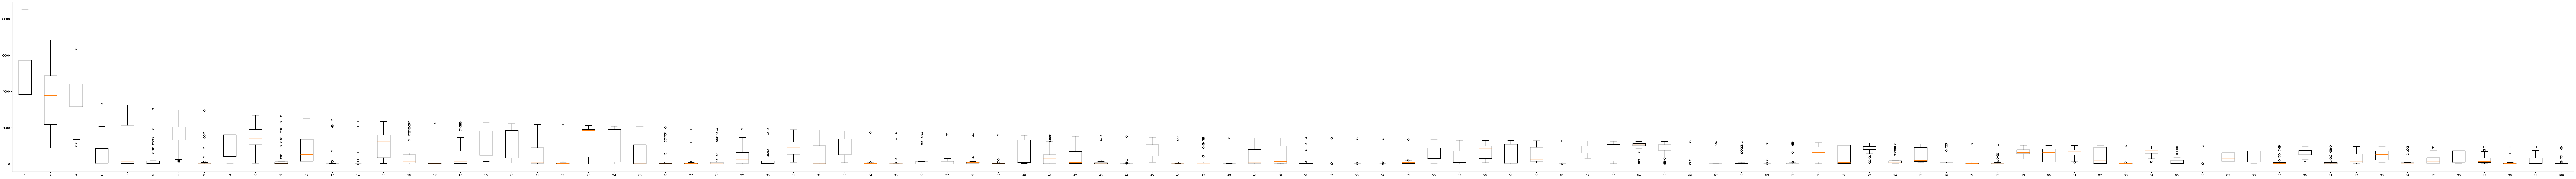

In [9]:
def draw_boxplot():
    plt.figure( figsize = ( 150, 10 ) )
    plt.boxplot( data.iloc[ :, :100 ] )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/boxplot.png", bbox_inches = 'tight', dpi = 100 )

if Flags.DRAW_PLOTS:
    draw_boxplot()

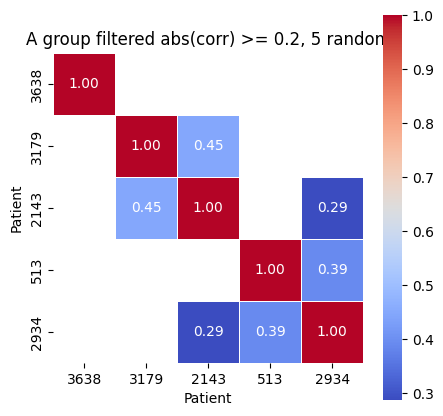

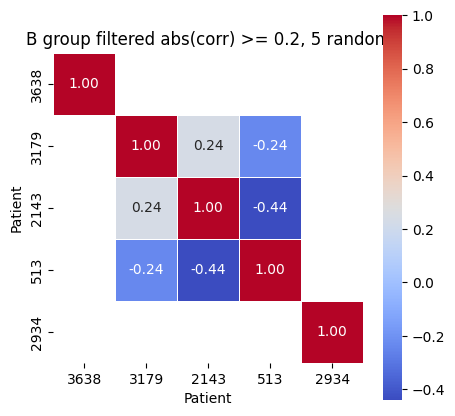

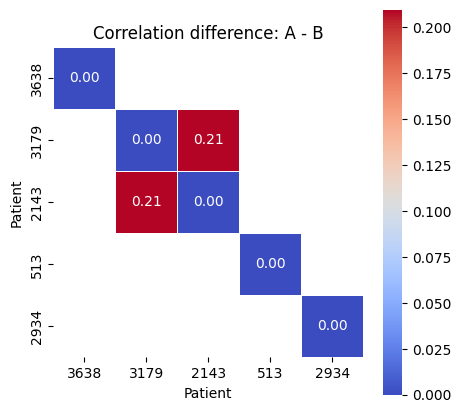

In [10]:
def draw_heatmaps( samples: int, size: int, filter: float ):
    data_subset = data.sample( axis = 1, n = samples )
    a_group = data_subset[:30]
    b_group = data_subset[30:]
    a_corr = a_group.corr()
    a_filtered_corr = a_corr[ a_corr.abs() >= filter ]
    b_corr = b_group.corr()
    b_filtered_corr = b_corr[ b_corr.abs() >= filter ]

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( a_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'A group filtered abs(corr) >= { filter }, { samples } random' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/a_filtered.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( b_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'B group filtered abs(corr) >= { filter }, { samples } random' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/b_filtered.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( a_filtered_corr - b_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'Correlation difference: A - B' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/corr_diff.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

if Flags.DRAW_PLOTS:
    draw_heatmaps( 5, 5, 0.2 )

# Model classification

In [6]:
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import warnings

SEED = 321 

In [7]:
# Lets put aside a small test set, so we can check performance of different classifiers against it
disease_train, disease_test, disease_y_train, disease_y_test = train_test_split(data, Util.binary_target, test_size = 0.2, shuffle = True, random_state=SEED)   

In [8]:
print(disease_y_train.sum())
print(disease_test.shape)

22
(12, 5457)


In [9]:
rfc = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=534, max_features='sqrt')

rfc.fit(disease_train, disease_y_train)

RandomForestClassifier(n_estimators=200, random_state=534)

In [10]:
# rfc = XGBClassifier(n_estimators=200, criterion='gini', random_state=534, max_features='sqrt')

# rfc.fit(disease_train, disease_y_train)

In [11]:

most_important = sorted(list(enumerate(rfc.feature_importances_)), key=lambda k:-k[1])
most_important

[(349, 0.0225074162252357),
 (685, 0.017672661880105703),
 (256, 0.01755030443486216),
 (178, 0.016121231610372367),
 (488, 0.015521217968734893),
 (701, 0.013810663862711839),
 (157, 0.013745024926145844),
 (129, 0.011591981290016097),
 (723, 0.011091440279174192),
 (385, 0.009549839736325266),
 (177, 0.009398615531874708),
 (475, 0.008966741392578715),
 (365, 0.008949188533876266),
 (126, 0.008889635604672291),
 (798, 0.00873450514925567),
 (152, 0.0087105457657033),
 (138, 0.0078783988957902),
 (333, 0.007768758878607364),
 (173, 0.007060977362558389),
 (551, 0.0069913320978051766),
 (585, 0.0069504123702384575),
 (97, 0.006905878177870075),
 (175, 0.006585410998204601),
 (746, 0.006531067498809435),
 (406, 0.006464863291357599),
 (518, 0.006405448431327358),
 (379, 0.006349661066902446),
 (430, 0.006288844387597808),
 (181, 0.006218868929301878),
 (502, 0.005956570796052499),
 (1080, 0.00594437639655031),
 (526, 0.0059382202289595095),
 (320, 0.005835842511859341),
 (437, 0.0057819

In [12]:
data.columns[[k[0] for k in most_important[:5]]]

Index([349, 685, 256, 178, 488], dtype='int64', name='Patient')

In [13]:
y_pred = rfc.predict(disease_test)
print(classification_report(disease_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



In [14]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
folds = enumerate(kfold.split(data, Util.binary_target))


## Random forest

In [15]:
# f1_scores = []
roc_auc_scores = []
folds = enumerate(kfold.split(data, Util.binary_target))
for fold, (train, test) in folds:
    print(f'Fold {fold}:')
    x_train, y_train = data.iloc[train], Util.binary_target[train]
    x_test, y_test = data.iloc[test], Util.binary_target[test]
    print(x_train.shape, x_test.shape)

    rfc = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=534, max_features='sqrt')
    rfc.fit(x_train, y_train)

    y_pred = rfc.predict(x_test)
    # score = f1_score(y_test, y_pred)
    # f1_scores.append(score)
    # print(f'f1 score = {score}')

    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_scores.append(roc_auc)
    print(f'roc auc score = {roc_auc:.2f}')

    print()

roc_auc_scores = np.array(roc_auc_scores)
print('min: %.2f, max: %.2f, avg %.2f' % (roc_auc_scores.min(), roc_auc_scores.max(), roc_auc_scores.mean()))

Fold 0:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 1:
(54, 5457) (6, 5457)
roc auc score = 0.67

Fold 2:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 3:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 4:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 5:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 6:
(54, 5457) (6, 5457)
roc auc score = 0.67

Fold 7:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 8:
(54, 5457) (6, 5457)
roc auc score = 1.00

Fold 9:
(54, 5457) (6, 5457)
roc auc score = 0.67

min: 0.67, max: 1.00, avg 0.80


## XGBoost

In [17]:
data.columns

RangeIndex(start=0, stop=5457, step=1, name='Patient')

In [23]:
roc_auc_scores = []
folds = enumerate(kfold.split(data, Util.binary_target))
for fold, (train, test) in folds:
    print(f'Fold {fold}:')
    x_train, y_train = data.iloc[train], Util.binary_target[train]
    x_test, y_test = data.iloc[test], Util.binary_target[test]
    print(x_train.shape, x_test.shape)

    clf = XGBClassifier(random_state=534, n_jobs=4)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    # score = f1_score(y_test, y_pred)
    # f1_scores.append(score)
    # print(f'f1 score = {score}')

    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_scores.append(roc_auc)
    print(f'roc auc score = {roc_auc:.2f}')

    print()

print(roc_auc_scores)
roc_auc_scores = np.array(roc_auc_scores)
print('min: %.2f, max: %.2f, avg %.2f' % (roc_auc_scores.min(), roc_auc_scores.max(), roc_auc_scores.mean()))

Fold 0:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 1:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 2:
(54, 5457) (6, 5457)
roc auc score = 0.67

Fold 3:
(54, 5457) (6, 5457)
roc auc score = 1.00

Fold 4:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 5:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 6:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 7:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 8:
(54, 5457) (6, 5457)
roc auc score = 1.00

Fold 9:
(54, 5457) (6, 5457)
roc auc score = 1.00

[0.8333333333333334, 0.8333333333333334, 0.6666666666666667, 1.0, 0.8333333333333333, 0.8333333333333334, 0.8333333333333334, 0.8333333333333333, 1.0, 1.0]
min: 0.67, max: 1.00, avg 0.87


## Linear Discriminant Analysis for classification

In [36]:
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

roc_auc_scores = []
folds = enumerate(kfold.split(data, Util.binary_target))
for fold, (train, test) in folds:
    print(f'Fold {fold}:')
    x_train, y_train = data.iloc[train], Util.binary_target[train]
    x_test, y_test = data.iloc[test], Util.binary_target[test]
    print(x_train.shape, x_test.shape)

    clf = LinearDiscriminantAnalysis()
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    # score = f1_score(y_test, y_pred)
    # f1_scores.append(score)
    # print(f'f1 score = {score}')

    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_scores.append(roc_auc)
    print(f'roc auc score = {roc_auc:.2f}')

    print()

print(roc_auc_scores)
roc_auc_scores = np.array(roc_auc_scores)
print('min: %.2f, max: %.2f, avg: %.2f, median: %.2f' % 
      (roc_auc_scores.min(), roc_auc_scores.max(), roc_auc_scores.mean(), np.median(roc_auc_scores)))

Fold 0:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 1:
(54, 5457) (6, 5457)
roc auc score = 1.00

Fold 2:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 3:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 4:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 5:
(54, 5457) (6, 5457)
roc auc score = 1.00

Fold 6:
(54, 5457) (6, 5457)
roc auc score = 0.67

Fold 7:
(54, 5457) (6, 5457)
roc auc score = 0.67

Fold 8:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 9:
(54, 5457) (6, 5457)
roc auc score = 0.67

[0.8333333333333334, 1.0, 0.8333333333333333, 0.8333333333333334, 0.8333333333333333, 1.0, 0.6666666666666667, 0.6666666666666667, 0.8333333333333333, 0.6666666666666667]
min: 0.67, max: 1.00, avg: 0.82, median: 0.83
